# Another strategy : Latent Dirichlet Allocation models

LDA is another way of modelling natural text:

* a topic is a vector of 'associated' weighted words

LDA is a way to reduce dimensionality and find the best set of topics (and therefore the best set of words for each topic) that represent the best a corpus (or loose the less information given a number of topics)

So given a doc, you can compute a signature, its linear combination of topics and say for example a doc is 80% of topic 'money' and 20% of topic 'family' In our kaggle challenge we could compute signature of both questions and check the distance between signatures

Here, we are using tools to display the set of topics. Rudely:

* the more distant the circles are, the best separated the topics are and so the best quality the model is
* the bigger the circle, the bigger the importance of the topic

In [1]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='lda_visualisation'
print_alert('You will work on experiment %s' %EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

## First steps
* load our best dataset
* Do some manual browsing
* Apply kind of brute force : show wordcloud on the whole dataset

In [2]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

# This will get back the name of the newsgroup with maximum proba for both questions
NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'forsale', #2
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]

def find_best_newsgroup(r):
    probas = [r['proba_'+c+'_question1'] for c in NEWSGROUP_LABELS]
    max_idx_1 = numpy.argsort(probas)[-1]
    max_1 = probas[max_idx_1]
    return (max_1,NEWSGROUP_LABELS[max_idx_1])

def load_lemmatized_newgroups(dataframe):
    # Bootstrap with our last full save
 
    print_warning('Glue lemmatized questions')
    lemmatized_questions = load_global_dataframe('train_lemmatized')
    dataframe['lemmatized_question1'] = lemmatized_questions['question1']
    del lemmatized_questions

    print_warning('Glue newsgroups')
    newsgroup_proba = load_global_dataframe('train_newsgroup_proba') 
    #we get back best newsgroup and its proba for both questions
    print_warning('find best newsgroups')
    add_column_from_columns(newsgroup_proba,'tmp',find_best_newsgroup)
    add_column_from_column(newsgroup_proba,'proba_newsgroup_1','tmp',lambda t: t[0])
    add_column_from_column(newsgroup_proba,'newsgroup_1','tmp',lambda t: t[1])
    dataframe[['proba_newsgroup_1','newsgroup_1']] = newsgroup_proba[['proba_newsgroup_1','newsgroup_1']]
    del newsgroup_proba

    # remove plenty of useless columns : we look only text and maybe 2 probas
    dataframe=dataframe.drop(columns=[c for c in all_numeric_columns(dataframe) if 'newsgroup' not in c])

    return dataframe

In [3]:
train_dataframe = load_or_build_dataframe('Prepare data for training visualisation','train_lda_visu',load_lemmatized_newgroups,train_dataframe)


What do we have as textual data ?

In [4]:
ALL_STRING_COLUMNS=[c for c in train_dataframe.columns if train_dataframe.dtypes[c] not in ['int64','float64']]
ALL_NUMERIC_COLUMNS=all_numeric_columns(train_dataframe)
print_section('All string columns')
print_info(str(ALL_STRING_COLUMNS))
print_section('All numeric columns')
print_info(str(ALL_NUMERIC_COLUMNS))


# describe ALL_STRING_COLUMNS takes HOURS...
# Mandatory to cache it !!
#train_dataframe[ALL_STRING_COLUMNS].describe()
#train_describe = load_or_build_dataframe('Build naive description of train','train_describe',lambda d: d.describe(),train_dataframe[ALL_STRING_COLUMNS])

# Better to describe one column at a time
train_dataframe[['question1','lemmatized_question1']]


,question1,lemmatized_question1
0,What is the step by step guide to invest in share market in india?,what be the step by step guide to invest in share market in india
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,what be the story of kohinoor koh i noor diamond
2,How can I increase the speed of my internet connection while using a VPN?,how can i increase the speed of my internet connection while use a vpn
3,Why am I mentally very lonely? How can I solve it?,why be i mentally very lonely how can i solve it
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",which one dissolve in water quikly sugar salt methane and carbon di oxide
...,...,...
404285,How many keywords are there in the Racket programming language of the latest version?,how many keyword be there in the racket programme language of the late version
404286,Do you believe there is life after death?,do you believe there be life after death
404287,What is one coin?,what be one coin
404288,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?",what be the approx annual cost of live while study in uic chicago for a indian student


Try to find the best number of topics.

Just try a number and follow the coherence a dedicated metric

In [14]:
import gensim
from gensim import corpora,models,similarities
from gensim.models import CoherenceModel
import pyLDAvis.gensim

def explore_lda(dataframe,focus,tries_nb_topics):
    start=time.time()
    print_section('Find best number of topics')
    print_info('Focus on %s: %d questions' % (focus,len(politics)))

    dictionary = corpora.Dictionary(dataframe.str.split())
    corpus = [dictionary.doc2bow(text) for text in dataframe.str.split()]
    tfidf = models.TfidfModel(corpus)
    transformed_tfidf = tfidf[corpus]
    perplexities = []
    coherence = []
    lda_models = []
    for nb_topics in tqdm(tries_nb_topics):
        start_model=time.time()
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=nb_topics, 
            random_state=42,
            update_every=1,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        perplexities.append(lda_model.log_perplexity(corpus))
        lda_models.append(lda_model)
        coherence_lda_model = CoherenceModel(model=lda_model, texts=politics.str.split(), dictionary=dictionary, coherence='c_v')
        print_done('Nb Topics %d Perplexity: %f - Coherence %f' % (nb_topics,lda_model.log_perplexity(corpus),coherence_lda_model.get_coherence()),top=start_model)
        coherence.append(coherence_lda_model.get_coherence())
    print_done('Done',top=start)
    return pandas.DataFrame({'coherence': coherence,'perplexity':perplexities,'lda_model':lda_models},index=tries_nb_topics)


,coherence,perplexity
3,0.265202,-6.200137
4,0.281683,-6.224557
5,0.290581,-6.222862
6,0.307571,-6.227707
7,0.347548,-6.226424
8,0.359363,-6.254661
9,0.350589,-6.262557
10,0.392925,-6.354497
11,0.367506,-6.469072
12,0.382625,-6.601247


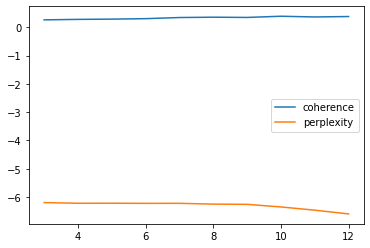

In [8]:
politics = train_dataframe[(train_dataframe['newsgroup_1']=='politics') & (train_dataframe['proba_newsgroup_1']>0.8)]['lemmatized_question1']
# tries_nb_topics = [3,4,10, 20,30] + list(range(5, 100, 10))
tries_nb_topics = [3,4,5,6,7,8,9,10,11,12]
res_lda = explore_lda(politics,'politics',tries_nb_topics)
display(res_lda)


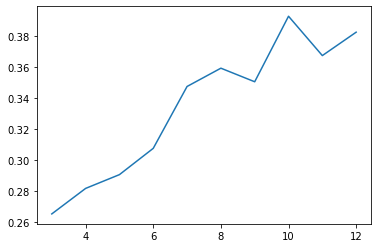

In [15]:
res_lda['coherence'].plot()

In [16]:
res= explore_lda(politics,'politics',[10])

In [25]:
res['lda_model'][10]

In [32]:

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

lda_model =res['lda_model'][10]
dictionary = corpora.Dictionary(politics.str.split())
corpus = [dictionary.doc2bow(text) for text in politics.str.split()]
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pandas.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[numpy.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = numpy.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = numpy.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9276 samples in 0.008s...
[t-SNE] Computed neighbors for 9276 samples in 0.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9276
[t-SNE] Computed conditional probabilities for sample 2000 / 9276
[t-SNE] Computed conditional probabilities for sample 3000 / 9276
[t-SNE] Computed conditional probabilities for sample 4000 / 9276
[t-SNE] Computed conditional probabilities for sample 5000 / 9276
[t-SNE] Computed conditional probabilities for sample 6000 / 9276
[t-SNE] Computed conditional probabilities for sample 7000 / 9276
[t-SNE] Computed conditional probabilities for sample 8000 / 9276
[t-SNE] Computed conditional probabilities for sample 9000 / 9276
[t-SNE] Computed conditional probabilities for sample 9276 / 9276
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.044510
[t-SNE] KL divergence after 1000 iterations: 0.744880


Loading BokehJS ...